# Laboratorio 1 
**José Barrios - 20007192**

## Descripción general
Utilizar el mismo dataset del proyecto de Introducción a la Ciencia de los Datos para implementar Batch Gradient Descent usando TensorFlow y TensorBoard.

Se pide hallar los parámetros de la función y
> y = f(x) = mx +b

Donde:
<br>y = la variable dependiente
<br>x = variable independiente
<br>m = pendiente de la recta(parámetro del modelo)
<br>b = intercepto(parámetro del modelo)

Tanto “x” como “y” son parte del dataset usado , “m” y “b” son parámetros del modelo los cuales buscamos estimar con los datos, esto significa que se busca encontrar que valores de “m” y “b” producen una recta que describa de la mejor manera posible la relación entre los datos "x" y "y".

Se usará el proyecto del curso anterior como base de este laboratorio. El proyecto se encuentra en el repositorio https://github.com/yaxha/mds-idc-proyecto 

Además, se utilizará este ejemplo para la implementación con Python https://www.geeksforgeeks.org/linear-regression-using-tensorflow/ 

Para este proyecto, ya no se utilizarán las variables _m_ y _b_ directamente, sino que se convertirán a las posiciones de un vector $theta$ de tamaño 2.

### Pasos solicitados
Los datos se encuentran dados en el formato binario de NumPy .npy por lo tanto usaremos la función “load” de numpy para poderlos utilizar:


In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
#import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [3]:
%load_ext tensorboard

In [4]:
data = np.load('proyecto_training_data.npy')

In [5]:
data = pd.DataFrame(data = data, columns = ["SalePrice", "OverallQual","1stFlrSF", "TotRmsAbvGrd", "YearBuilt", "LotFrontage"])
data = data.astype({"SalePrice" : int, "OverallQual" : int, "1stFlrSF" : int, "TotRmsAbvGrd" : int, "YearBuilt" : int})
data.head()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
0,208500,7,856,8,2003,65.0
1,181500,6,1262,6,1976,80.0
2,223500,7,920,6,2001,68.0
3,140000,7,961,7,1915,60.0
4,250000,8,1145,9,2000,84.0


In [5]:
data.describe()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000
mean,180921.195890,6.099315,1162.626712,6.517808,1971.267808,70.049958
std,79442.502883,1.382997,386.587738,1.625393,30.202904,24.284752
min,34900.000000,1.000000,334.000000,2.000000,1872.000000,21.000000
25%,129975.000000,5.000000,882.000000,5.000000,1954.000000,59.000000
50%,163000.000000,6.000000,1087.000000,6.000000,1973.000000,69.000000
75%,214000.000000,7.000000,1391.250000,7.000000,2000.000000,80.000000
max,755000.000000,10.000000,4692.000000,14.000000,2010.000000,313.000000


In [6]:
print("Forma o tamaño: ", data.shape)

Forma o tamaño:  (1460, 6)


### Correlación entre variables
Para cada variable independiente x:
* Calcular el coeficiente de correlación entre x y _y_ 
* Graficar x vs y (scatterplot) usando matplotlib
* Colocar el coeficiente de correlación y colocarlo como parte del título de la gráfica

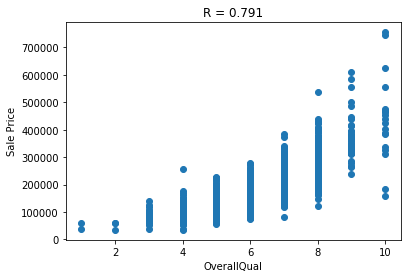

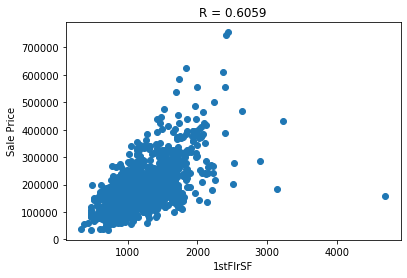

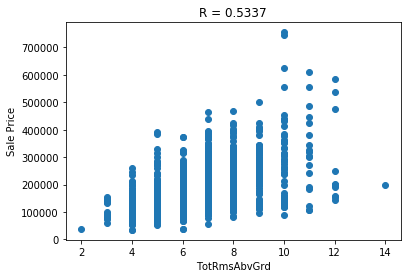

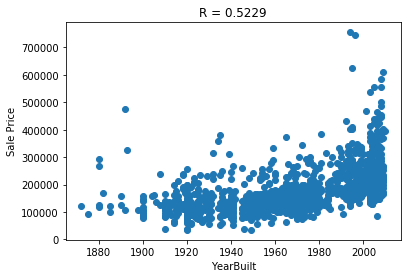

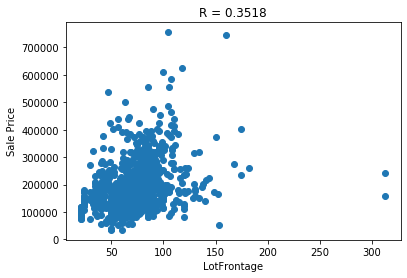

In [9]:
for col in data.columns:
    if(col != 'SalePrice'):
        cor = round(data['SalePrice'].corr(data[col]),4)
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(data[col], data["SalePrice"])
        ax.set_xlabel(col)
        ax.set_ylabel("Sale Price")
        ax.set_title('R = ' + str(cor))
        ax.set_aspect('auto')
    
plt.show()

## Variable seleccionada
Según las correlaciones entre variables de la sección anterior, se selecciona:
* OverallQual (R = 0.791)

## Definición del método de entrenamiento
Se crea una clase para entrenar un modelo de regresión lineal de una variable. Sin embargo, se tratará de parametrizar para que sea capaz de recibir más de una variable independiente, de este modo se generaliza para que la función de la variable dependiente sea:
> $y = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n$


In [6]:
#Clase del modelo lineal
class LinearRegression:
    #Inicializador de thetas a 0
    def __init__(self, n): 
        self.theta = tf.get_variable("theta", dtype=tf.float32, shape=[1, n], initializer=tf.zeros_initializer())

    def __call__(self, x):
        return tf.matmul(self.theta, x)
    
    #Función a optimizar por tf.gradients
    def mse(self, x, y):
        mse = 0.5 * tf.reduce_mean(tf.math.square(y - self(x)))
        return mse
    
    #Actualización de thetas
    def update(self, x, y, learning_rate):
        with tf.name_scope("cost_function"):
            mse = self.mse(x, y)
            mse_summary = tf.summary.scalar("mse_summary", mse)
        gradients = tf.gradients(mse, [self.theta])
        theta_new = tf.assign(self.theta, self.theta - learning_rate * gradients[0])
        return theta_new, mse, mse_summary

In [7]:
#Función de entrenamiento usando la clase definida anteriormente
def LinearTraining(x, y, epochs, imprimir_error_cada, learning_rate):
    log_name = './logs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_lr=' + str(learning_rate)+ '_epochs=' + str(epochs)
    
    n, m = x.shape
    g = tf.Graph()
    with g.as_default():
        model = LinearRegression(n)
        tensor_x = tf.placeholder(tf.float32, [n, m], "tensor_x")
        tensor_y = tf.placeholder(tf.float32, [m], "tensor_y")
        
        update_parameters = model.update(tensor_x, tensor_y, learning_rate)
        
        writer = tf.summary.FileWriter(log_name, g)
        
        with tf.train.MonitoredSession() as session:
            parameters_dict = {tensor_x:x, tensor_y:y}
            for i in range(epochs + 1):
                training = session.run(update_parameters, feed_dict = parameters_dict)
            
                if (i % imprimir_error_cada) == 0:
                    W = session.run(model.theta, feed_dict = parameters_dict)
                    writer.add_summary(training[2], i)
                    print("Epoch ", i, ": Thetas: ", W, "Cost: ", training[1])

## Entrenamiento
Ya definido el modelo, se utilizará para graficar el grafo resultante y el costo del entrenamiento en el tiempo. Para el entrenamiento se asume que la función de costo tiene un mínimo y la "velocidad" para alcanzarlo depende de la tasa de aprendizaje sin que esta tasa provoque divergencia.

<img src="images/grafo.png">

In [8]:
y = data["SalePrice"]
x = data["OverallQual"]
x = np.array([x, np.ones_like(x)], dtype = "float32")

In [9]:
LinearTraining(x, y, 1000, 100, 0.01)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch  0 : Thetas:  [[11903.399  1809.212]] Cost:  19519640000.0
Epoch  100 : Thetas:  [[30432.057     -109.074814]] Cost:  1406328000.0
Epoch  200 : Thetas:  [[31131.19   -4586.9214]] Cost:  1385769500.0
Epoch  300 : Thetas:  [[31797.744 -8856.112]] Cost:  1367081900.0
Epoch  400 : Thetas:  [[ 32433.238 -12926.37 ]] Cost:  1350095700.0
Epoch  500 : Thetas:  [[ 33039.12  -16806.963]] Cost:  1334655500.0
Epoch  600 : Thetas:  [[ 33616.77  -20506.734]] Cost:  1320620900.0
Epoch  700 : Thetas:  [[ 34167.504 -24034.111]] Cost:  1307863600.0
Epoch  800 : Thetas:  [[ 34692.574 -27397.113]] Cost:  1296267800.0
Epoch  900 : Thetas:  [[ 35193.176 -30603.414]] Cost:  1285727200.0
Epoch  1000 : Thetas:  [[ 35670.453 -33660.312]] Cost:  1276145900.0


In [12]:
LinearTraining(x, y, 10000, 300, 0.01)
#Este experimento redujo el costo a comparación del anterior. Acá se agregaron más iteraciones

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch  0 : Thetas:  [[11903.399  1809.212]] Cost:  19519640000.0
Epoch  300 : Thetas:  [[31797.744 -8856.112]] Cost:  1367081900.0
Epoch  600 : Thetas:  [[ 33616.77  -20506.734]] Cost:  1320620900.0
Epoch  900 : Thetas:  [[ 35193.176 -30603.414]] Cost:  1285727200.0
Epoch  1200 : Thetas:  [[ 36559.33  -39353.438]] Cost:  1259521200.0
Epoch  1500 : Thetas:  [[ 37743.258 -46936.344]] Cost:  1239839400.0
Epoch  1800 : Thetas:  [[ 38769.285 -53507.902]] Cost:  1225057500.0
Epoch  2100 : Thetas:  [[ 39658.453 -59202.92 ]] Cost:  1213956000.0
Epoch  2400 : Thetas:  [[ 40429.023 -64138.332]] Cost:  1205618300.0
Epoch  2700 : Thetas:  [[ 41096.82  -68415.484]] Cost:  1199356200.0
Epoch  3000 : Thetas:  [[ 41675.555 -72122.17 ]] Cost:  1194653700.0
Epoch  3300 : Thetas:  [[ 42177.086 -75334.44 ]] Cost:  1191121500.0
Epoch  3600 : Thetas:  [[ 42611.727 -78118.25 ]] Cost:  11884

In [13]:
LinearTraining(x, y, 10000, 500, 0.001)
#En este experimento se redujo el learning rate para ver su efecto.
#Se observó que el costo disminuye mucho más lentamente que el experimento anterior

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch  0 : Thetas:  [[1190.3401   180.92122]] Cost:  19519640000.0
Epoch  500 : Thetas:  [[30063.1     2254.0488]] Cost:  1417369100.0
Epoch  1000 : Thetas:  [[30425.45      -66.77994]] Cost:  1406332500.0
Epoch  1500 : Thetas:  [[30779.254  -2332.9036]] Cost:  1395810300.0
Epoch  2000 : Thetas:  [[31124.738 -4545.61 ]] Cost:  1385778300.0
Epoch  2500 : Thetas:  [[31462.062  -6706.1606]] Cost:  1376212900.0
Epoch  3000 : Thetas:  [[31791.438 -8815.782]] Cost:  1367093900.0
Epoch  3500 : Thetas:  [[ 32113.059 -10875.679]] Cost:  1358399400.0
Epoch  4000 : Thetas:  [[ 32427.084 -12887.015]] Cost:  1350110600.0
Epoch  4500 : Thetas:  [[ 32733.715 -14850.943]] Cost:  1342206800.0
Epoch  5000 : Thetas:  [[ 33033.12  -16768.555]] Cost:  1334672900.0
Epoch  5500 : Thetas:  [[ 33325.43  -18640.957]] Cost:  1327488600.0
Epoch  6000 : Thetas:  [[ 33610.902 -20469.213]] Cost:  1

In [14]:
LinearTraining(x, y, 100000, 500, 0.01)
#En este experimento empecé a notar la importancia de tensorboard 
#ya que graficamente podía ver la disminución del costo a comparación de los otros experimentos.
#Con este set de datos ya no es tan relevante una gran cantidad de epochs
#Los siguiente experimentos serán con 25,000 epochs en vez de los 100,000 de este

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch  0 : Thetas:  [[11903.399  1809.212]] Cost:  19519640000.0
Epoch  500 : Thetas:  [[ 33039.12  -16806.963]] Cost:  1334655500.0
Epoch  1000 : Thetas:  [[ 35670.453 -33660.312]] Cost:  1276145900.0
Epoch  1500 : Thetas:  [[ 37743.258 -46936.344]] Cost:  1239839400.0
Epoch  2000 : Thetas:  [[ 39376.09  -57394.418]] Cost:  1217309800.0
Epoch  2500 : Thetas:  [[ 40662.33 -65632.6 ]] Cost:  1203329200.0
Epoch  3000 : Thetas:  [[ 41675.555 -72122.17 ]] Cost:  1194653700.0
Epoch  3500 : Thetas:  [[ 42473.7  -77234.22]] Cost:  1189270400.0
Epoch  4000 : Thetas:  [[ 43102.45 -81261.27]] Cost:  1185930200.0
Epoch  4500 : Thetas:  [[ 43597.723 -84433.42 ]] Cost:  1183857400.0
Epoch  5000 : Thetas:  [[ 43987.87 -86932.28]] Cost:  1182570800.0
Epoch  5500 : Thetas:  [[ 44295.203 -88900.695]] Cost:  1181772200.0
Epoch  6000 : Thetas:  [[ 44537.305 -90451.32 ]] Cost:  118127690

In [15]:
LinearTraining(x, y, 25000, 500, 0.05)
#cambiando el learning rate de 0.01 a 0.05
#diverge

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch  0 : Thetas:  [[59517.     9046.061]] Cost:  19519640000.0
Epoch  500 : Thetas:  [[192722.73  -41986.625]] Cost:  472523100000.0
Epoch  1000 : Thetas:  [[820070.7   34198.89]] Cost:  12280543000000.0
Epoch  1500 : Thetas:  [[4006261.    525067.44]] Cost:  319915440000000.0
Epoch  2000 : Thetas:  [[20264366.   3061457.5]] Cost:  8334672000000000.0
Epoch  2500 : Thetas:  [[1.0324766e+08 1.6017145e+07]] Cost:  2.1714259e+17
Epoch  3000 : Thetas:  [[5.2681338e+08 8.2148888e+07]] Cost:  5.657247e+18
Epoch  3500 : Thetas:  [[2.6887859e+09 4.1970045e+08]] Cost:  1.4738875e+20
Epoch  4000 : Thetas:  [[1.3723943e+10 2.1426307e+09]] Cost:  3.8399126e+21
Epoch  4500 : Thetas:  [[7.004994e+10 1.093693e+10]] Cost:  1.0004176e+23
Epoch  5000 : Thetas:  [[3.5755436e+11 5.5825400e+10]] Cost:  2.6064604e+24
Epoch  5500 : Thetas:  [[1.8250524e+12 2.8494941e+11]] Cost:  6.790721e+

In [16]:
LinearTraining(x, y, 25000, 500, 0.025)
#El learning rate anterior se dividió a la mitad para comprobar el comportamiento
#Encontró el minimo local entre el epoch 8500 y el 9000

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch  0 : Thetas:  [[29758.5     4523.0303]] Cost:  19519640000.0
Epoch  500 : Thetas:  [[ 36776.66  -40745.418]] Cost:  1255804900.0
Epoch  1000 : Thetas:  [[ 40667.78 -65667.55]] Cost:  1203309600.0
Epoch  1500 : Thetas:  [[ 42810.367 -79390.52 ]] Cost:  1187392900.0
Epoch  2000 : Thetas:  [[ 43990.168 -86946.984]] Cost:  1182567400.0
Epoch  2500 : Thetas:  [[ 44639.777 -91107.64 ]] Cost:  1181103700.0
Epoch  3000 : Thetas:  [[ 44997.49  -93398.734]] Cost:  1180660200.0
Epoch  3500 : Thetas:  [[ 45194.45 -94660.25]] Cost:  1180526000.0
Epoch  4000 : Thetas:  [[ 45302.902 -95354.87 ]] Cost:  1180484700.0
Epoch  4500 : Thetas:  [[ 45362.617 -95737.336]] Cost:  1180472400.0
Epoch  5000 : Thetas:  [[ 45395.504 -95947.98 ]] Cost:  1180468900.0
Epoch  5500 : Thetas:  [[ 45413.613 -96063.95 ]] Cost:  1180467500.0
Epoch  6000 : Thetas:  [[ 45423.582 -96127.81 ]] Cost:  118

In [17]:
LinearTraining(x, y, 15000, 500, 0.0375)
#Se redujo la cantidad de epochs y cambió el learning rate
#al punto medio entre 0.05 y 0.025
#Encontró el minimo en el epoch 6000

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch  0 : Thetas:  [[44637.75    6784.5454]] Cost:  19519640000.0
Epoch  500 : Thetas:  [[ 39015.863 -55087.203]] Cost:  1221928400.0
Epoch  1000 : Thetas:  [[ 42813.348 -79409.59 ]] Cost:  1187385300.0
Epoch  1500 : Thetas:  [[ 44364.57  -89344.984]] Cost:  1181621600.0
Epoch  2000 : Thetas:  [[ 44998.223 -93403.43 ]] Cost:  1180659600.0
Epoch  2500 : Thetas:  [[ 45257.06 -95061.25]] Cost:  1180499500.0
Epoch  3000 : Thetas:  [[ 45362.777 -95738.375]] Cost:  1180472300.0
Epoch  3500 : Thetas:  [[ 45405.97  -96015.016]] Cost:  1180468000.0
Epoch  4000 : Thetas:  [[ 45423.617 -96128.01 ]] Cost:  1180467300.0
Epoch  4500 : Thetas:  [[ 45430.824 -96174.17 ]] Cost:  1180467500.0
Epoch  5000 : Thetas:  [[ 45433.754 -96192.95 ]] Cost:  1180467100.0
Epoch  5500 : Thetas:  [[ 45434.945 -96200.586]] Cost:  1180467200.0
Epoch  6000 : Thetas:  [[ 45435.453 -96203.85 ]] Cost:  1

In [18]:
LinearTraining(x, y, 15000, 500, 0.04375)
#Learning rate entre 0.05 y 0.0375
#Encontró el minimo en el epoch 5500

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch  0 : Thetas:  [[52077.375   7915.3027]] Cost:  19519640000.0
Epoch  500 : Thetas:  [[ 39908.28  -60803.055]] Cost:  1211221200.0
Epoch  1000 : Thetas:  [[ 43491.17  -83750.984]] Cost:  1184273300.0
Epoch  1500 : Thetas:  [[ 44751.668 -91824.3  ]] Cost:  1180938100.0
Epoch  2000 : Thetas:  [[ 45195.133 -94664.59 ]] Cost:  1180525400.0
Epoch  2500 : Thetas:  [[ 45351.133 -95663.77 ]] Cost:  1180474000.0
Epoch  3000 : Thetas:  [[ 45406.016 -96015.27 ]] Cost:  1180468200.0
Epoch  3500 : Thetas:  [[ 45425.324 -96138.95 ]] Cost:  1180467200.0
Epoch  4000 : Thetas:  [[ 45432.12 -96182.48]] Cost:  1180467100.0
Epoch  4500 : Thetas:  [[ 45434.496 -96197.7  ]] Cost:  1180467300.0
Epoch  5000 : Thetas:  [[ 45435.33 -96203.05]] Cost:  1180466800.0
Epoch  5500 : Thetas:  [[ 45435.508 -96204.2  ]] Cost:  1180467000.0
Epoch  6000 : Thetas:  [[ 45435.508 -96204.2  ]] Cost:  118

In [19]:
LinearTraining(x, y, 15000, 500, 0.045)
#Último experimento donde se alcanza el minimo con 5500 epochs
# y un learning rate de 0.045 (rango antes de alcanzar la divergencia)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch  0 : Thetas:  [[53565.3     8141.4546]] Cost:  19519640000.0
Epoch  500 : Thetas:  [[ 40071.332 -61847.33 ]] Cost:  1209437000.0
Epoch  1000 : Thetas:  [[ 43604.094 -84474.25 ]] Cost:  1183844500.0
Epoch  1500 : Thetas:  [[ 44810.36 -92200.21]] Cost:  1180860900.0
Epoch  2000 : Thetas:  [[ 45222.24 -94838.25]] Cost:  1180513300.0
Epoch  2500 : Thetas:  [[ 45362.87 -95738.99]] Cost:  1180472400.0
Epoch  3000 : Thetas:  [[ 45410.902 -96046.59 ]] Cost:  1180467800.0
Epoch  3500 : Thetas:  [[ 45427.3  -96151.61]] Cost:  1180467300.0
Epoch  4000 : Thetas:  [[ 45432.9   -96187.484]] Cost:  1180467100.0
Epoch  4500 : Thetas:  [[ 45434.8  -96199.66]] Cost:  1180467000.0
Epoch  5000 : Thetas:  [[ 45435.49 -96204.08]] Cost:  1180466800.0
Epoch  5500 : Thetas:  [[ 45435.508 -96204.2  ]] Cost:  1180467000.0
Epoch  6000 : Thetas:  [[ 45435.508 -96204.2  ]] Cost:  1180467000.

In [10]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 10548), started 0:44:26 ago. (Use '!kill 10548' to kill it.)

## Conclusión
Se determina que el mejor experimento es el que tenga un learning rate entre 0.04375 y 0.045 antes de alcanzar la divergencia en 0.05. 
<img src="images/costo.png">